In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import splitfolders
from sklearn.model_selection import train_test_split

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

In [3]:
dataset_dir = './defungi'
output_dir = './Train_test_split'

#Split into train, test, validation
splitfolders.ratio(dataset_dir, output=output_dir, seed=42, ratio=(.6, .2, .2), group_prefix=None)

In [4]:
train_data_dir = './Train_test_split/train'
test_data_dir = './Train_test_split/test'
val_data_dir = './Train_test_split/val'

In [5]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE,
    subset = 'training',
    validation_split = 0.2,
    seed = 42
)

val_data = tf.keras.utils.image_dataset_from_directory(
    val_data_dir,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE,
    #subset = 'validation',
    #validation_split = 0.2,
    seed = 42
)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE,
)

Found 5466 files belonging to 5 classes.
Using 4373 files for training.
Found 1819 files belonging to 5 classes.
Found 1829 files belonging to 5 classes.


In [6]:
class_names = train_data.class_names
class_names

['H1', 'H2', 'H3', 'H5', 'H6']

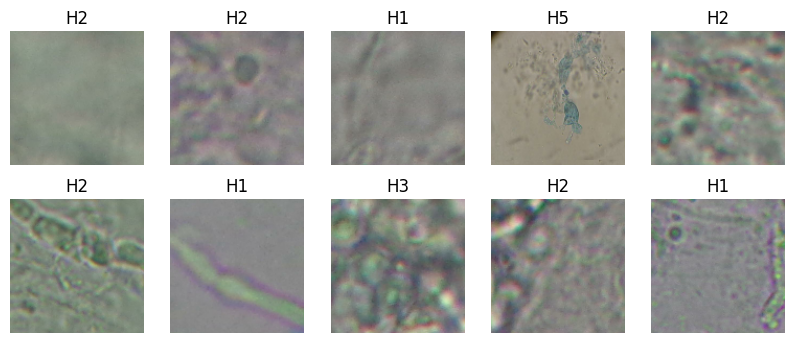

In [7]:
#plot data sample
plt.figure(figsize=(10,4))
for image,label in train_data.take(1):
  for i in range(10):
    ax = plt.subplot(2,5,i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(class_names[label[i]])
    plt.axis("off")

In [8]:
#Normalize all the pixel values to 0-1
train_data = train_data.map(lambda x,y: (x/255, y)) #Dividing by 255 since every value is in range 0 - 255
val_data = val_data.map(lambda x,y: (x/255, y))
test_data = test_data.map(lambda x,y: (x/255, y))

In [9]:
#Print pixel values of a bormalized image
for image,label in train_data.take(1):
  for i in range(1):
    print(image)

tf.Tensor(
[[[[0.5568628  0.5564951  0.57824755]
   [0.5543505  0.5476103  0.5781154 ]
   [0.56286764 0.5479779  0.5921569 ]
   ...
   [0.5294118  0.54509807 0.5411765 ]
   [0.5294118  0.54509807 0.5411765 ]
   [0.51550245 0.5311887  0.52726716]]

  [[0.5579657  0.5661152  0.5803922 ]
   [0.5589786  0.5568628  0.57858646]
   [0.55974936 0.55005455 0.58564836]
   ...
   [0.5254902  0.5411765  0.5372549 ]
   [0.5254902  0.5411765  0.5372549 ]
   [0.52156866 0.5372549  0.53333336]]

  [[0.55582106 0.5735907  0.5753313 ]
   [0.5536018  0.56618315 0.5776482 ]
   [0.55609775 0.55370617 0.5757056 ]
   ...
   [0.5194537  0.53514    0.5312184 ]
   [0.5201593  0.5358456  0.531924  ]
   [0.5176471  0.53333336 0.5294118 ]]

  ...

  [[0.56078434 0.58431375 0.5372549 ]
   [0.56078434 0.58431375 0.5372549 ]
   [0.5550245  0.5785539  0.5314951 ]
   ...
   [0.5411765  0.5372549  0.5294118 ]
   [0.53474265 0.5308211  0.52297795]
   [0.5294118  0.52156866 0.5254902 ]]

  [[0.5647059  0.5764706  0.533333

In [10]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal",input_shape=(128,128,3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

e:\Education\CNN-Image-Classifier\myenv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
#Model Building
model = tf.keras.models.Sequential()

model.add(data_augmentation)

model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(256, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))

model.add(tf.keras.layers.Dense(5, activation='softmax'))

In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,607,429 (6.13 MB)

 Trainable params: 1,606,469 (6.13 MB)

 Non-trainable params: 960 (3.75 KB)

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                #from_logits=True,
                ignore_class=None,
                reduction='sum_over_batch_size'
              ),
              metrics=['accuracy'])

In [14]:
history = model.fit(train_data,
                    epochs=20,
                    validation_data=val_data)

Epoch 1/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 83s 573ms/step - accuracy: 0.5439 - loss: 1.1467 - val_accuracy: 0.4838 - val_loss: 1.4937
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 68s 498ms/step - accuracy: 0.6320 - loss: 0.9097 - val_accuracy: 0.4838 - val_loss: 2.0071
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 68s 499ms/step - accuracy: 0.6711 - loss: 0.8247 - val_accuracy: 0.5311 - val_loss: 1.3871
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 67s 490ms/step - accuracy: 0.6672 - loss: 0.8117 - val_accuracy: 0.6152 - val_loss: 1.0633
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 68s 497ms/step - accuracy: 0.6775 - loss: 0.8022 - val_accuracy: 0.6905 - val_loss: 0.7969
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 67s 491ms/step - accuracy: 0.6992 - loss: 0.7518 - val_accuracy: 0.7097 - val_loss: 0.7336
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 67s 488ms/step - accuracy: 0.7117 - loss: 0.7314 - val_accuracy: 0.6652 - val_loss: 0.7950
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 68s 493ms/step - accuracy: 0.7108 - loss: 0